In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from rule_based import RuleBasedRecommendation
from collaborative import CollaborativeFiltering
from content_based import ContentBasedFiltering
from surprise import SVD, KNNBasic
import numpy as np

# Function to calculate nDCG
from sklearn.metrics import dcg_score

def calculate_ndcg(true_ratings, predicted_ratings, k=10):
    relevance = np.asarray(true_ratings[:k])
    predicted_relevance = np.asarray(predicted_ratings[:k])
    dcg = dcg_score([relevance], [predicted_relevance])
    idcg = dcg_score([relevance], [relevance])  # Ideal DCG
    return dcg / idcg if idcg > 0 else 0

# Load Dataset Paths
ratings_file = '/teamspace/studios/this_studio/u.data'
metadata_file = '/teamspace/studios/this_studio/u.item'

# Initialize Models
rule_based = RuleBasedRecommendation(ratings_file, metadata_file)
collaborative_svd = CollaborativeFiltering(ratings_file, metadata_file, algorithm='svd')
collaborative_user_user = CollaborativeFiltering(ratings_file, metadata_file, algorithm='user-user')
collaborative_item_item = CollaborativeFiltering(ratings_file, metadata_file, algorithm='item-item')
content_based = ContentBasedFiltering(ratings_file, metadata_file)

In [2]:
# Fit Models
print("Fitting Collaborative Filtering (SVD)...")
collaborative_svd.fit()

print("Fitting Collaborative Filtering (User-User)...")
collaborative_user_user.fit()

print("Fitting Collaborative Filtering (Item-Item)...")
collaborative_item_item.fit()

Fitting Collaborative Filtering (SVD)...
Fitting Collaborative Filtering (User-User)...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Fitting Collaborative Filtering (Item-Item)...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [3]:
# Evaluate Models
print("Evaluating Rule-Based Recommendation (Top Overall)...")
top_overall = rule_based.top_overall()
print(top_overall)

print("\nEvaluating Collaborative Filtering (SVD)...")
rmse_svd = collaborative_svd.evaluate()
print(f"RMSE (SVD): {rmse_svd}")

# Evaluate nDCG for Collaborative Filtering (SVD)
true_ratings = collaborative_svd.validset
predictions = collaborative_svd.model.test(true_ratings)
sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)
true_relevance = [rating.r_ui for rating in sorted_predictions]
predicted_relevance = [rating.est for rating in sorted_predictions]
ndcg_svd = calculate_ndcg(true_relevance, predicted_relevance, k=10)
print(f"nDCG (SVD): {ndcg_svd}")

print("\nEvaluating Collaborative Filtering (User-User)...")
rmse_user_user = collaborative_user_user.evaluate()
print(f"RMSE (User-User): {rmse_user_user}")

# Evaluate nDCG for Collaborative Filtering (User-User)
predictions = collaborative_user_user.model.test(true_ratings)
sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)
true_relevance = [rating.r_ui for rating in sorted_predictions]
predicted_relevance = [rating.est for rating in sorted_predictions]
ndcg_user_user = calculate_ndcg(true_relevance, predicted_relevance, k=10)
print(f"nDCG (User-User): {ndcg_user_user}")

print("\nEvaluating Collaborative Filtering (Item-Item)...")
rmse_item_item = collaborative_item_item.evaluate()
print(f"RMSE (Item-Item): {rmse_item_item}")

# Evaluate nDCG for Collaborative Filtering (Item-Item)
predictions = collaborative_item_item.model.test(true_ratings)
sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)
true_relevance = [rating.r_ui for rating in sorted_predictions]
predicted_relevance = [rating.est for rating in sorted_predictions]
ndcg_item_item = calculate_ndcg(true_relevance, predicted_relevance, k=10)
print(f"nDCG (Item-Item): {ndcg_item_item}")

print("\nEvaluating Content-Based Filtering...")
rmse_content_based = content_based.evaluate(sample_size=1000)
print(f"RMSE (Content-Based): {rmse_content_based}")

# Evaluate nDCG for Content-Based Filtering
sample_ratings = content_based.ratings.sample(n=1000, random_state=42)
true_relevance = sample_ratings['rating'].tolist()
predicted_relevance = [content_based.predict(row['user'], row['item']) for _, row in sample_ratings.iterrows()]
sorted_indices = np.argsort(predicted_relevance)[::-1]
true_relevance_sorted = [true_relevance[i] for i in sorted_indices]
predicted_relevance_sorted = [predicted_relevance[i] for i in sorted_indices]
ndcg_content_based = calculate_ndcg(true_relevance_sorted, predicted_relevance_sorted, k=10)
print(f"nDCG (Content-Based): {ndcg_content_based}")

Evaluating Rule-Based Recommendation (Top Overall)...
      item                                              title
813    814                      Great Day in Harlem, A (1994)
1121  1122                     They Made Me a Criminal (1939)
1188  1189                                 Prefontaine (1997)
1200  1201         Marlene Dietrich: Shadow and Light (1996) 
1292  1293                                    Star Kid (1997)
1466  1467               Saint of Fort Washington, The (1993)
1499  1500                          Santa with Muscles (1996)
1535  1536                               Aiqing wansui (1994)
1598  1599                      Someone Else's America (1995)
1652  1653  Entertaining Angels: The Dorothy Day Story (1996)

Evaluating Collaborative Filtering (SVD)...
RMSE: 0.9363
RMSE (SVD): 0.9363330073289491
nDCG (SVD): 0.9856009879593528

Evaluating Collaborative Filtering (User-User)...
RMSE: 1.0194
RMSE (User-User): 1.0193536815834319
nDCG (User-User): 0.9967271614334623

Evalu

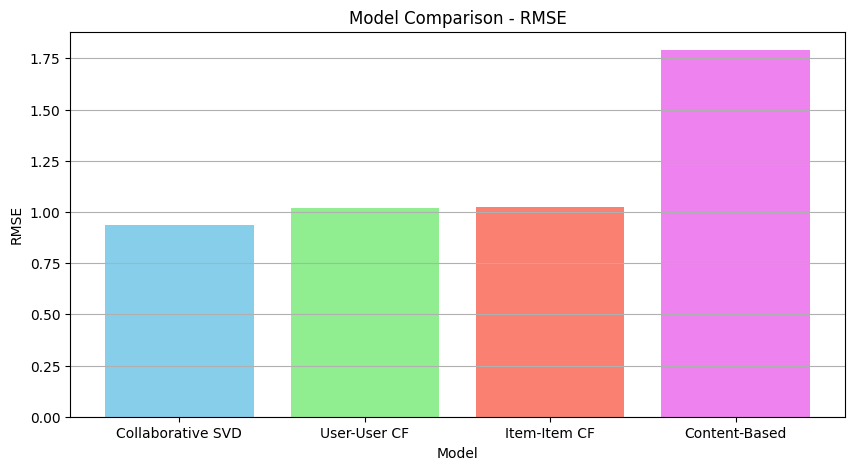

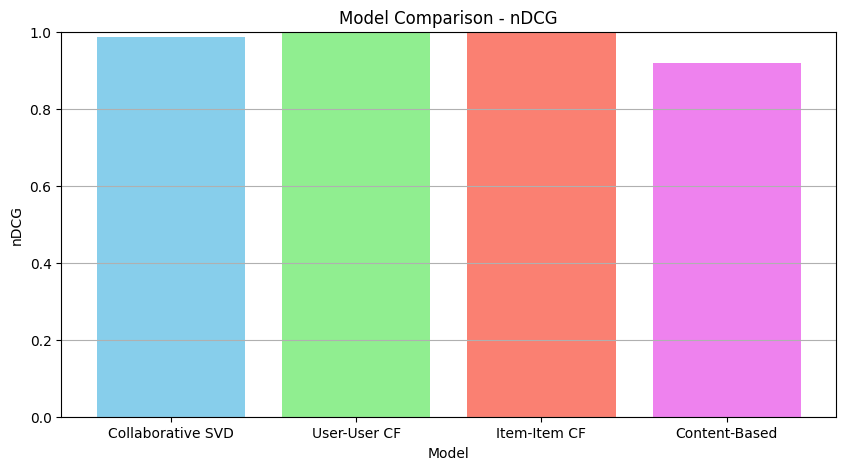

In [4]:
# Visualize Performance Comparison
model_names = ['Collaborative SVD', 'User-User CF', 'Item-Item CF', 'Content-Based']
rmse_values = [rmse_svd, rmse_user_user, rmse_item_item, rmse_content_based]
ndcg_values = [ndcg_svd, ndcg_user_user, ndcg_item_item, ndcg_content_based]

plt.figure(figsize=(10, 5))
plt.bar(model_names, rmse_values, color=['skyblue', 'lightgreen', 'salmon', 'violet'])
plt.title('Model Comparison - RMSE')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(model_names, ndcg_values, color=['skyblue', 'lightgreen', 'salmon', 'violet'])
plt.title('Model Comparison - nDCG')
plt.xlabel('Model')
plt.ylabel('nDCG')
plt.grid(axis='y')
plt.ylim(0, 1)
plt.show()

### Collaborative Filtering with SVD
The Collaborative Filtering with SVD model emerged as the most effective among the evaluated methods. With an RMSE of 0.9363, this model had the lowest prediction error, indicating that it was able to predict user ratings with a high degree of accuracy. A low RMSE implies that the model effectively captures latent factors in the user-item interaction matrix, resulting in more accurate recommendations. In addition to its strong accuracy, the nDCG value of 0.9856 indicates that the model also performs well in ranking items in a way that is relevant to users. A high nDCG value means that users are likely to see their most relevant items at the top of the recommendation list, thus improving user satisfaction and engagement.

### User-User Collaborative Filtering
The User-User Collaborative Filtering model also performed well, though not as effectively as SVD. With an RMSE of 1.0194, this model had slightly higher prediction errors, suggesting that the predicted ratings were not as close to actual user ratings compared to SVD. Nevertheless, its performance is still acceptable and highlights its effectiveness in finding similarities among users based on shared preferences. The nDCG value for User-User Collaborative Filtering was 0.9967, which is very close to perfect. This means that while the model may have a slightly higher prediction error, it is highly effective at ranking items in an order that users are likely to find most relevant. The strong nDCG score indicates that the model can provide a meaningful ranking of items, making it a valuable approach for recommending items to users based on similar user behaviors.

### Item-Item Collaborative Filtering
The Item-Item Collaborative Filtering model had an RMSE of 1.0264, which was similar to the User-User Collaborative Filtering model, indicating a slightly higher error compared to SVD. This model identifies items that are similar based on users’ past behaviors and recommends those similar items. One notable result for Item-Item Collaborative Filtering was its nDCG value of 1.0, which indicates a perfect ranking of recommended items for the evaluated test set. This means that, according to the ranking metrics, the items recommended by the model were exactly in the order that would be most relevant to users. This high ranking performance makes the Item-Item model highly suitable for use cases where the quality of the ranked list is of utmost importance, such as when recommending products that are similar to something the user has already liked or purchased.

### Content-Based Filtering
The Content-Based Filtering model, unlike the collaborative approaches, uses item features, such as genres, to make recommendations. This model had the highest RMSE of 1.7904, indicating that its predictions were significantly less accurate than the collaborative filtering models. This is likely because relying solely on genres does not capture the complexity of individual user preferences as effectively as collaborative methods do. Furthermore, the nDCG value for Content-Based Filtering was 0.9179, which, while still decent, was the lowest among the models evaluated. This suggests that the ranking quality of the items recommended by the Content-Based Filtering model is not as good as that of the collaborative models. This limitation could be due to the model’s inability to effectively differentiate user preferences beyond the basic genre level, which means that the recommendations might not be as fine-tuned to individual users as the other methods.